![Fuel Saving, the Hoff way!](https://media1.tenor.com/images/09bb20a1e40457b7897ee99a13b6a8a9/tenor.gif?itemid=7202134)

<h1 style = "font-family:verdana; background-color:#C5D6FA"><center>I. Predicting Fuel Consumption - Pipelines Step by
Step</center></h1>
<p><center style="color:#1F4BA7; font-family:cursive;">Exploration of the prediction of fuel consumption using
Machine Learning - Let the Hoff lead the way!</center></p>

For this analysis we use the Auto-mpg dataset found on the Kaggle Data Repository at the following location:

<a href=https://www.kaggle.com/uciml/autompg-dataset>Auto-mpg dataset</a>

"The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued
discrete and 5 continuous attributes." (Quinlan, 1993)

"This dataset is a slightly modified version of the dataset provided in the StatLib library. In line with the use by
Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had
unknown values for the "mpg" attribute. The original dataset is available in the file "auto-mpg.data-original".

The Data Dictionary for this dataset is as follows:

| Variable | Definition | Type |
|----------|------------|-----|
| mpg | Miles per Gallon | Continuous |
| cylinders | No. of Cylinders  | Discrete |
| displacement | Size of engine | Continuous |
| horsepower | Power output | Continuous |
| weight | Vehicle weight | Continuous |
| acceleration | Vehicle acceleration | Continuous |
| model_year | Vehicle model | Discrete |
| origin | Vehicle country of manufacture | Discrete |
| car_name | Vehicle make and model | Unique |

The objective of this notebook is to do some high level analyses, implement a simple MLP regressor to predict MLP and
 to compare this implementation to an ML pipeline implementation for the same model. We compare manual hyperparameter
 tuning (network architecture and regularisation) for the simple MLP model to using GridSearchCV in the pipeline.

We also investigate the use of Response Curve otherwise known as Partial Dependency Plots (PDPs) for investigation of
 the relationship between various features and the responses. The PDPs also indicate how well the model fits the data
  from the perspective of different features, and is hence useful from two different perspectives.

In [59]:
from math import sqrt
from statistics import mean

import pandas as pd
import pandas_profiling
import seaborn as sns
from matplotlib import style
from mlens.ensemble import SuperLearner
from numpy import absolute, std
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, \
    ExtraTreesRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, learning_curve, \
    validation_curve
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools
import warnings

from sklearn.tree import DecisionTreeRegressor
from statsmodels.tools.eval_measures import mse

warnings.filterwarnings('ignore')


This utility function is used to plot learning curves.

In [60]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5), learn_scoring=None, scoring_title="Score"):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring=learn_scoring)

    if learn_scoring == "neg_mean_squared_error":
        train_scores_mean = -np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = -np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)
    else:
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    axes[0].set_ylabel(scoring_title)

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("Fit times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("Fit times")
    axes[2].set_ylabel(scoring_title)
    axes[2].set_title("Performance of the model")

    return plt

<h2 style = "font-family:verdana; background-color:#C5D6FA"><center>Load data</center></h2>

In [61]:
df = pd.read_csv('../data/processed/auto-mpg.csv', delimiter = ",")


Let us have a look at the original data:

In [62]:
df.shape


(398, 9)

In [63]:
df.head()


mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino

In [64]:
df_auto = df.copy()

We start by renaming columns to align with our data dictionary and then we One Hot Encode categorical variables.

In [65]:
# Rename columns to align with our data dictionary.
df_auto = df_auto.rename(columns = {'model year': 'model_year', 'car name': 'car_name'})
df_auto_orig = df_auto.copy()

We now split the car make from the model name. We do this by using a vectorised implementation of the transform. In
future we will create a transformer class for this, so that we can put this into a pipeline.

In [66]:
# Split car_name variable in make and model
df_auto['car_make'] = df_auto['car_name'].str.split(' ', 1).str.get(0)
df_auto['car_model'] = df_auto['car_name'].str.split(' ', 1).str.get(1)
df_auto.head()


mpg  cylinders  displacement horsepower  weight  acceleration  model_year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car_name   car_make        car_model  
0       1  chevrolet chevelle malibu  chevrolet  chevelle malibu  
1       1          buick skylark 320      buick      skylark 320  
2       1         plymouth satellite   plymouth        satellite  
3       1              amc rebel sst        amc        rebel sst  
4       1                ford torino       ford           torino

This looks OK for now!

Let us look at the variable types.

In [67]:
df_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
 9   car_make      398 non-null    object 
 10  car_model     396 non-null    object 
dtypes: float64(3), int64(4), object(4)
memory usage: 34.3+ KB


We observe some issues with some of the variables. The horsepower feature is clearly numeric, but is reported as an
object. Let us see what is the matter:

In [68]:
df_auto.loc[~df_auto['horsepower'].astype(str).str.isdigit()]


mpg  cylinders  displacement horsepower  weight  acceleration  \
32   25.0          4          98.0          ?    2046          19.0   
126  21.0          6         200.0          ?    2875          17.0   
330  40.9          4          85.0          ?    1835          17.3   
336  23.6          4         140.0          ?    2905          14.3   
354  34.5          4         100.0          ?    2320          15.8   
374  23.0          4         151.0          ?    3035          20.5   

     model_year  origin              car_name car_make      car_model  
32           71       1            ford pinto     ford          pinto  
126          74       1         ford maverick     ford       maverick  
330          80       2  renault lecar deluxe  renault   lecar deluxe  
336          80       1    ford mustang cobra     ford  mustang cobra  
354          81       2           renault 18i  renault            18i  
374          82       1        amc concord dl      amc     concord dl

Clearly we have some missing values indicates as strings. Let us fix this by converting these values to missing and
the rest of values to numeric.

We then reorganise the dataset and select columns we will use for the analysis.

In [69]:
df_auto = df_auto.replace('?', np.nan)
df_auto['horsepower'] = df_auto['horsepower'].astype(float)

In [70]:
categorical_cols = ['cylinders', 'model_year', 'origin']
quantitative_cols = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']
quantitative_cols_model = ['displacement', 'horsepower', 'weight', 'acceleration']
# Re-order columns
col_names = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year', 'origin',
             'car_make', 'car_model']
col_names_model = ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year', 'origin']
df_auto = df_auto.loc[:, col_names]

In [71]:
#df_auto_model = pd.get_dummies(df_auto, columns = categorical_cols, drop_first=True)
#cols = list(df_auto_model.columns.values)

The final analysis dataset looks as follows now:

In [72]:
df_auto.sample(10, random_state=0)

mpg  displacement  horsepower  weight  acceleration  cylinders  \
65   14.0         351.0       153.0    4129          13.0          8   
132  25.0         140.0        75.0    2542          17.0          4   
74   13.0         302.0       140.0    4294          16.0          8   
78   21.0         120.0        87.0    2979          19.5          4   
37   18.0         232.0       100.0    3288          15.5          6   
54   35.0          72.0        69.0    1613          18.0          4   
294  34.1          86.0        65.0    1975          15.2          4   
60   20.0         140.0        90.0    2408          19.5          4   
12   15.0         400.0       150.0    3761           9.5          8   
341  23.5         173.0       110.0    2725          12.6          6   

     model_year  origin   car_make         car_model  
65           72       1       ford       galaxie 500  
132          74       1  chevrolet              vega  
74           72       1       ford  gran torino (sw)  
78           72       2    peugeot          504 (sw)  
37           71       1        amc           matador  
54           71       3     datsun              1200  
294          79       3      maxda        glc deluxe  
60           72       1  chevrolet              vega  
12           70       1  chevrolet       monte carlo  
341          81       1  chevrolet          citation

Very nice!

We start with automated EDA and then follow up with further manual analysis. Exciting times...

<h2 style = "font-family:verdana; background-color:#C5D6FA"><center>Exploration of data</center></h2>

For this analysis we start by exploring the automatic EDA functionality in Pandas.

The notebook by Sercan Yeşilöz pointed us in this direction:

<a href=https://www.kaggle.com/sercanyesiloz/vehicle-fuel-consumption-prediction-xgboost>Vehicle Fuel Consumption
Prediction (XGBoost)</a>

In [73]:
df_auto.profile_report()

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Well the automated analysis tool turned out to be really cool! The main observations can be summarised from the
"Warnings" tab (sounds ominous!) as follows:

- Car model has high cardinality - almost 75% of the data has different values. I would have expected this value to
be unique, as this field should represent each different unique car. We will need to revisit this later.
- There is high correlation between several of the numeric feature variables. Given the nature of the variables this
is expected. Displacement is highly correlated with both cylinders and weight.
- Most variables have inverse correlation with mpg, which makes sense, given the nature of most variables i.e.
weight, displacement, cylinders etc. Typically refers to size and strength of car which would be inversely correlated
 to mpg.
- Acceleration, model year and origin are positively correlated, which again makes sense as newer and lighter cars
would have better fuel consumption (the correlation with acceleration is slightly surprising however as one would
expect heavier muscle cars to accelerate faster, but then again the majority of cars only had 4 cylinders...).

We will further investigate these observations in our manual analysis.

We continue by looking at missing values.

#### Missing values

We quantify the exact number of missing values in the data set:

In [74]:
# Check for null values
missing_values_train = df_auto.isnull().sum()
missing_values_train = missing_values_train.to_frame(name='num_missing')
missing_values_train['perc_missing'] = (missing_values_train['num_missing']/df_auto.shape[0])*100
for index, row in missing_values_train.iterrows():
    if (row['num_missing'] > 0):
        print ("For \"%s\" the number of missing values are: %d (%.0f%%)" %  (index,
                                                                     row['num_missing'],
                                                                    row['perc_missing']))

For "horsepower" the number of missing values are: 6 (2%)
For "car_model" the number of missing values are: 2 (1%)


There are missing values in the car model and horsepower fields.

We will impute values when we get to our model building phase.

#### Distribution analysis

Now we analyse the distribution of continuous variables to get a feel for the data.


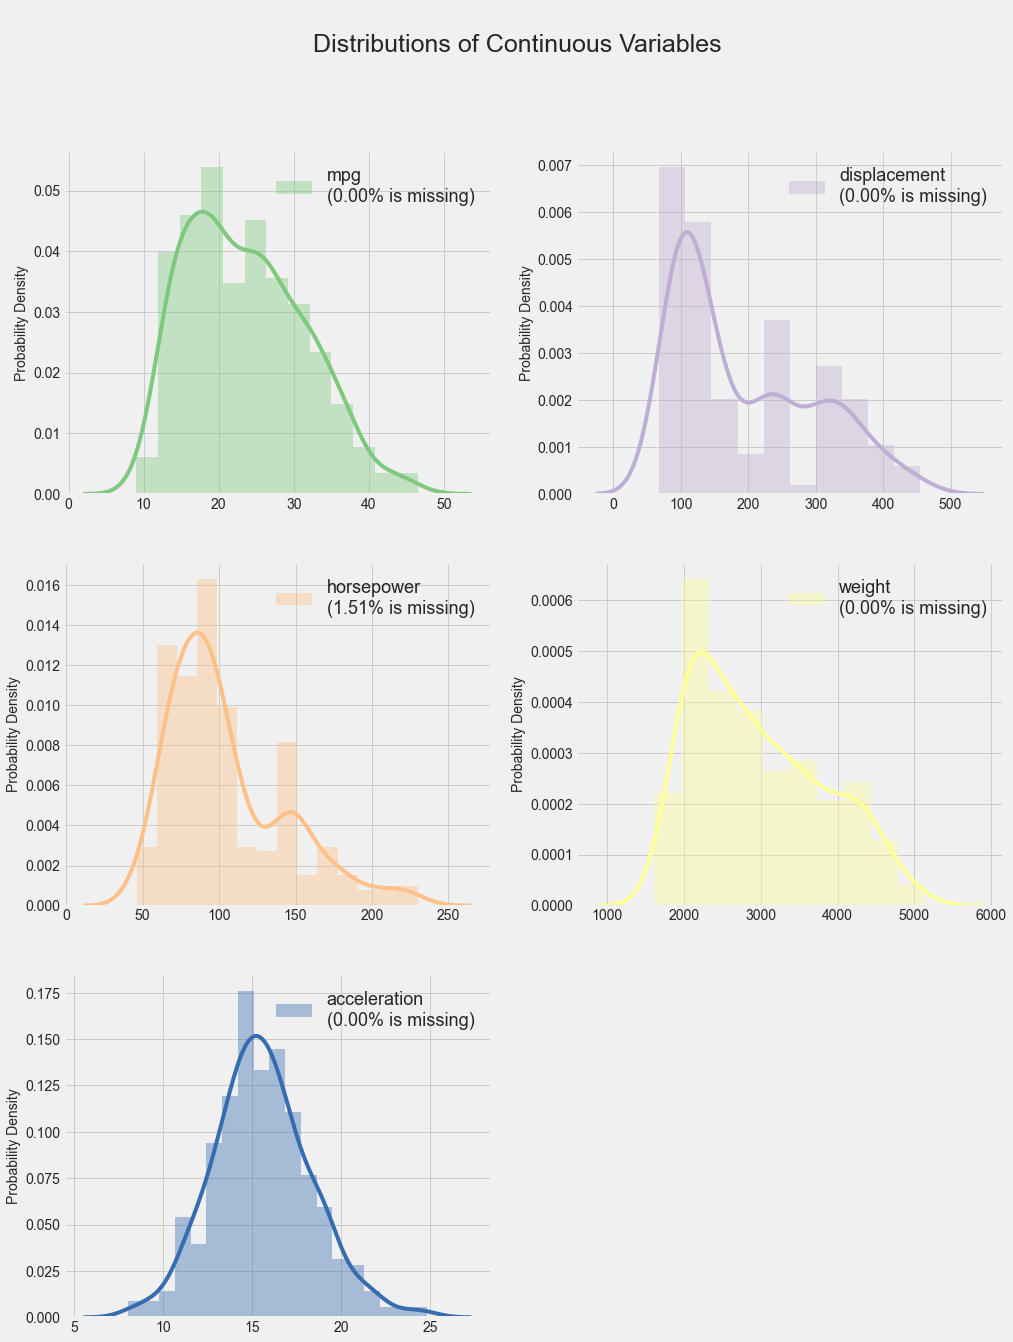

In [75]:
style.use('fivethirtyeight')
sns.set_palette('Accent')
palette = itertools.cycle(sns.color_palette('Accent'))

n_rows, n_cols = (3,2)

figure, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(15, 20))
figure.suptitle('\nDistributions of Continuous Variables', fontsize=25)

for index, column in enumerate(quantitative_cols):
    i,j = (index // n_cols), (index % n_cols)
    miss_perc="%.2f"%(100*(1-(df_auto[column].dropna().shape[0])/df_auto.shape[0]))
    collabel=column+"\n({}% is missing)".format(miss_perc)
    fig=sns.distplot(df_auto[column], label=collabel, norm_hist=True,
    ax=axes[i,j], kde_kws={"lw":4}, color=next(palette))
    fig=fig.legend(loc='best', fontsize=18)
    axes[i,j].set_ylabel("Probability Density",fontsize='medium')
    axes[i,j].set_xlabel(None)
figure.delaxes(axes[2,1])

plt.show()

There are no obvious outliers. Again we note the few missing values in the horsepower variable. Horsepower has a
bi-modal distribution, probably due to the segmentation of cars due to cylinders i.e. 4 cylinders vs 6 and 8. This
holds true for displacement and to a lesser extent weight too. The majority of cars however fall in the smaller
displacement category.

We will continue with analysis for now, and do a more in-depth EDA in a later notebook.

Next we consider the categorical variables.

In [76]:
style.use('seaborn-darkgrid')

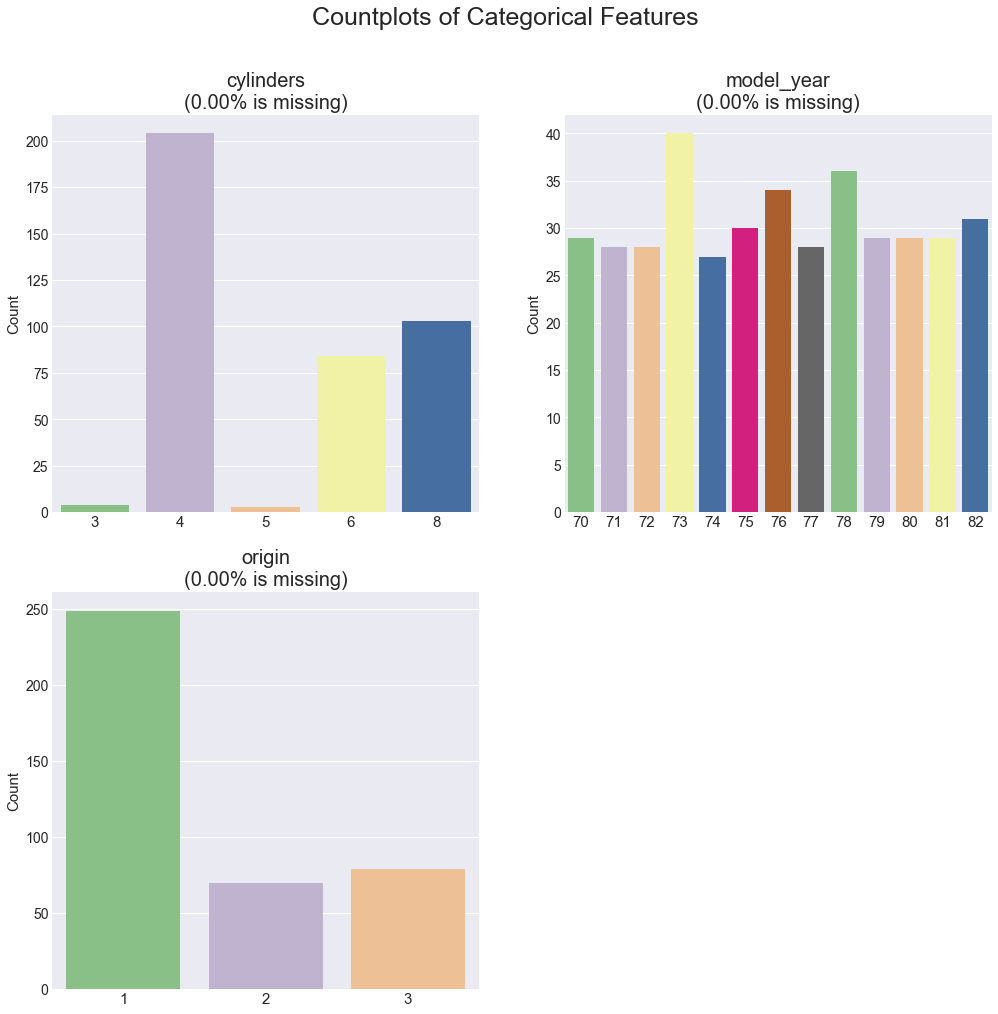

In [77]:
n_rows, n_cols = (2,2)

figure, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(15, 15))
figure.suptitle('Countplots of Categorical Features', fontsize=25)

for index, column in enumerate(categorical_cols):
    i,j = index // n_cols, index % n_cols
    miss_perc="%.2f"%(100*(1-(df_auto[column].dropna().shape[0])/df_auto.shape[0]))
    collabel=column+"\n({}% is missing)".format(miss_perc)
    fig = sns.countplot(x=column, data=df_auto,label=collabel, palette='Accent',
    ax=axes[i,j])
#order = df_auto[column].value_counts().index)
    axes[i,j].set_title(collabel,fontsize=20)
    axes[i,j].set_xlabel(None)
    axes[i,j].set_ylabel("Count",fontsize=15)
    axes[i,j].set_xticklabels(axes[i,j].get_xticklabels(), Fontsize=15)
figure.delaxes(axes[1,1])

plt.show()

There is good variation in all the categorical variables. It is however noticeable that more than 75% of data comes
from a specific origin. We need to find out more about where the different cars are made. Looking at the names this
is probably the US. The distribution of model years is fairly uniform. Most vehicles have 4 cylinders. This causes an
 imbalance with cars that have more cylinders e.g. 6 and 8. We need to keep this in mind.

We will perform a more in depth analysis later. We now look at pairwise relationships between variables.

<Figure size 432x288 with 0 Axes>

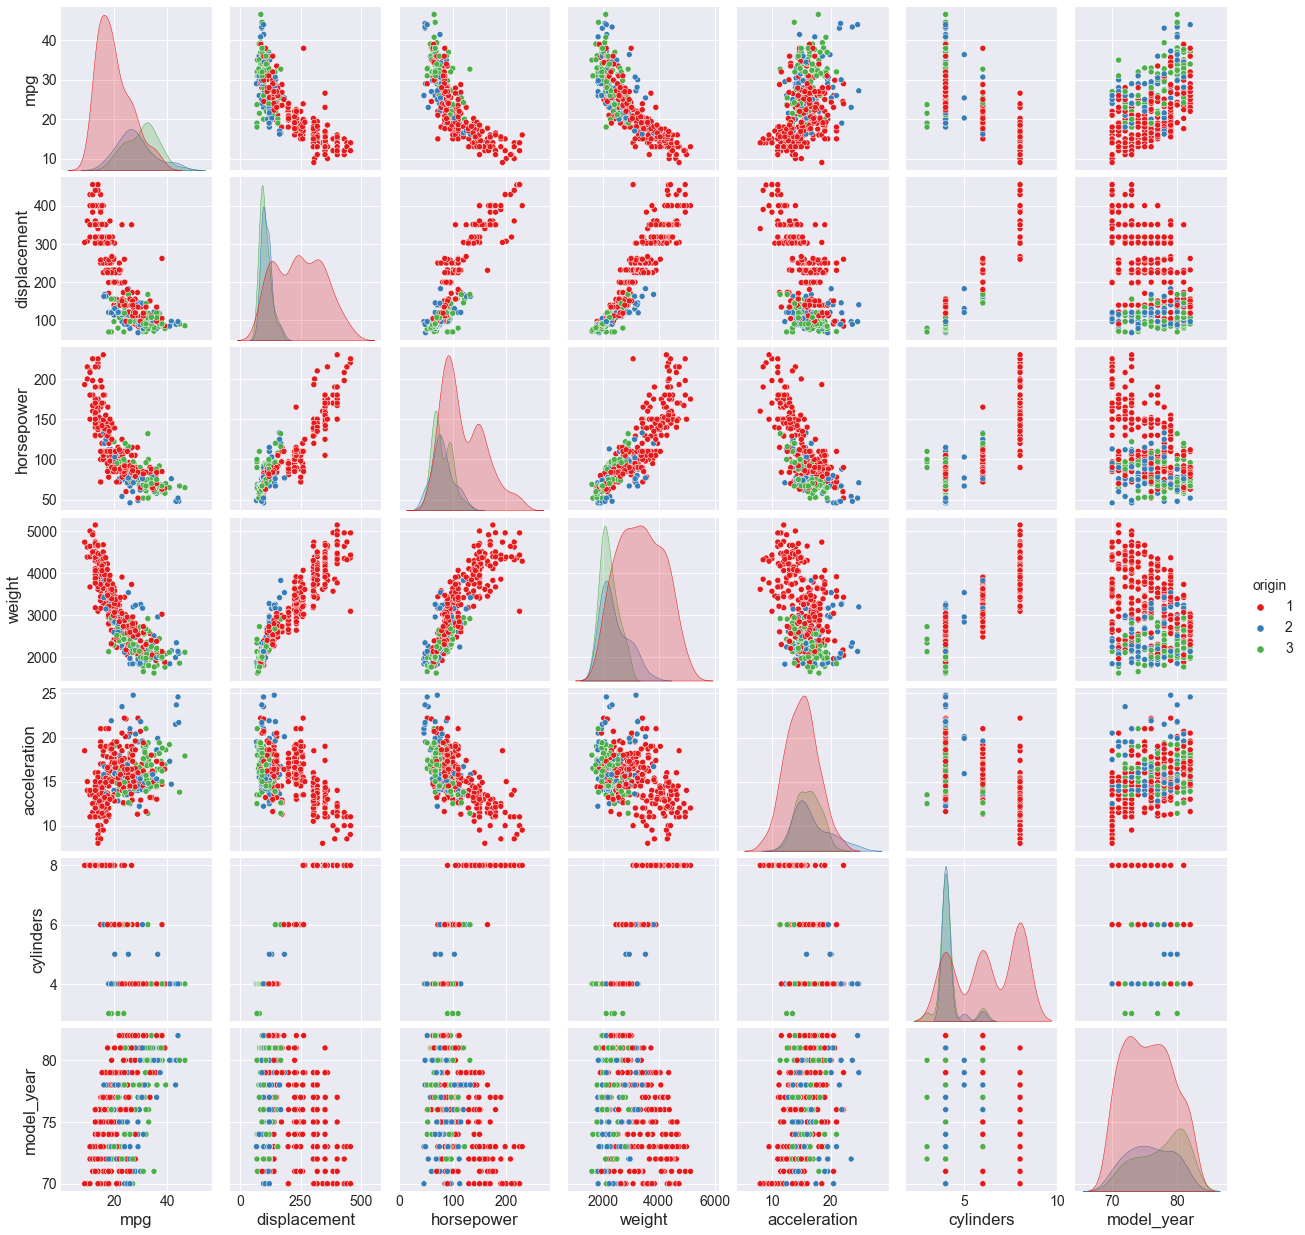

In [78]:
_ = plt.figure()
_ = sns.pairplot(df_auto, diag_kind = "kde",hue = "origin",kind = "scatter",palette = "Set1")
_ = plt.show()

The scatter plot nicely illustrates what our automated EDA showed already:

- Strong negative correlation between mpg and:
    - displacement
    - horsepower
    - weight
    - cylinders
- Weak positive correlation between mpg and:
    - acceleration
    - model year

We can also observe that the cars with higher displacement, horsepower and weight all come from origin number 1,
which we assume is the US. This is confirmed by the fact that nearly all the cars with 8 cylinders are from the same
origin. From the density function we also observe that distribution of mpg for this origin is markedly lower than other
origins.

We will now build our baseline MLP, and manually optimise hyperparameters i.e. network architecture and
regularisation parameter.

<h2 style = "font-family:verdana; background-color:#C5D6FA"><center>Build Baseline Models</center></h2>
<p><center style="color:#1F4BA7; font-family:cursive;">Using manual hyperparameter tuning</center></p>

We now build a baseline model (MLP) followed by setting up a model pipeline. We first manually optimise
hyper-parameters (for fun) and then we use GridSearchCV to optimise the parameters for us.

We start by imputing missing values. Data leakage takes place here. We will fix this going forward with an imputation
 transformer in our pipeline...

In [79]:
median = df_auto['horsepower'].median()
df_auto['horsepower'].fillna(median, inplace=True)
print("Number of null values in age column: {}".format(df_auto['horsepower'].isnull().sum()))

Number of null values in age column: 0


In [80]:
X = df_auto.iloc[:, 1:8]
y = df_auto.iloc[:, 0]

Our modelling dataset looks as follows after feature selection:

In [81]:
X.head()

displacement  horsepower  weight  acceleration  cylinders  model_year  \
0         307.0       130.0    3504          12.0          8          70   
1         350.0       165.0    3693          11.5          8          70   
2         318.0       150.0    3436          11.0          8          70   
3         304.0       150.0    3433          12.0          8          70   
4         302.0       140.0    3449          10.5          8          70   

   origin  
0       1  
1       1  
2       1  
3       1  
4       1

In [82]:
y.head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

In [83]:
y = np.ravel(y)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


Our training set has the following dimensions:

In [85]:
X_train.shape

(298, 7)

We now split and One Hot Encode categorical variables. Our dataset now looks as follows:

In [86]:
X_train = pd.get_dummies(X_train, columns = categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns = categorical_cols, drop_first=True)
cols_train = list(X_train.columns.values)
cols_test = list(X_test.columns.values)
X_train = pd.DataFrame(X_train, columns=cols_train)
X_test = pd.DataFrame(X_test, columns=cols_test)

In [87]:
X_train.head()

displacement  horsepower  weight  acceleration  cylinders_4  cylinders_5  \
254         200.0        85.0    2965          15.8            0            0   
246          78.0        52.0    1985          19.4            1            0   
282         140.0        88.0    2890          17.3            1            0   
81           97.0        92.0    2288          17.0            1            0   
347          85.0        65.0    1975          19.4            1            0   

     cylinders_6  cylinders_8  model_year_71  model_year_72  ...  \
254            1            0              0              0  ...   
246            0            0              0              0  ...   
282            0            0              0              0  ...   
81             0            0              0              1  ...   
347            0            0              0              0  ...   

     model_year_75  model_year_76  model_year_77  model_year_78  \
254              0              0              0              1   
246              0              0              0              1   
282              0              0              0              0   
81               0              0              0              0   
347              0              0              0              0   

     model_year_79  model_year_80  model_year_81  model_year_82  origin_2  \
254              0              0              0              0         0   
246              0              0              0              0         0   
282              1              0              0              0         0   
81               0              0              0              0         0   
347              0              0              1              0         0   

     origin_3  
254         0  
246         1  
282         0  
81          1  
347         1  

[5 rows x 22 columns]

In [88]:
# Manually enter columns here for testing, need to automate this.
quantitative_cols_model = ['displacement', 'horsepower', 'weight', 'acceleration']
categorical_cols_model = ['cylinders_4', 'cylinders_5', 'cylinders_6', 'cylinders_8', 'model_year_71', 'model_year_72',
                          'model_year_73', 'model_year_74', 'model_year_75', 'model_year_76', 'model_year_77',
                          'model_year_78', 'model_year_79', 'model_year_80', 'model_year_81', 'model_year_82',
                          'origin_2', 'origin_3']
all_cols_model =  ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders_4', 'cylinders_5',
                   'cylinders_6', 'cylinders_8', 'model_year_71', 'model_year_72', 'model_year_73', 'model_year_74',
                   'model_year_75', 'model_year_76', 'model_year_77', 'model_year_78', 'model_year_79', 'model_year_80',
                   'model_year_81', 'model_year_82', 'origin_2', 'origin_3']

Now we scale our numeric variables. We use a Column Transformer to do the job (neat way of separating categorical and
 numeric variable transformation).

In [89]:
std_scaler = ColumnTransformer(
            transformers=[('std_scaler', StandardScaler(), quantitative_cols_model)],
            remainder = 'passthrough')

X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)
X_train = pd.DataFrame(X_train, columns=cols_train)
X_test = pd.DataFrame(X_test, columns=cols_test)

Finally we build our baseline MLP and note baseline accuracy on test set.

In [90]:
reg = MLPRegressor(max_iter=100000, solver="lbfgs", activation="relu",hidden_layer_sizes=(5), random_state=1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_pred,y_test)

9.234061685819949

An MSE of just over 9. Let us see if we can improve on this by optimising the architecture and regularisation
parameters.
We now analyse the bias and variance in the model by plotting a learning curve.

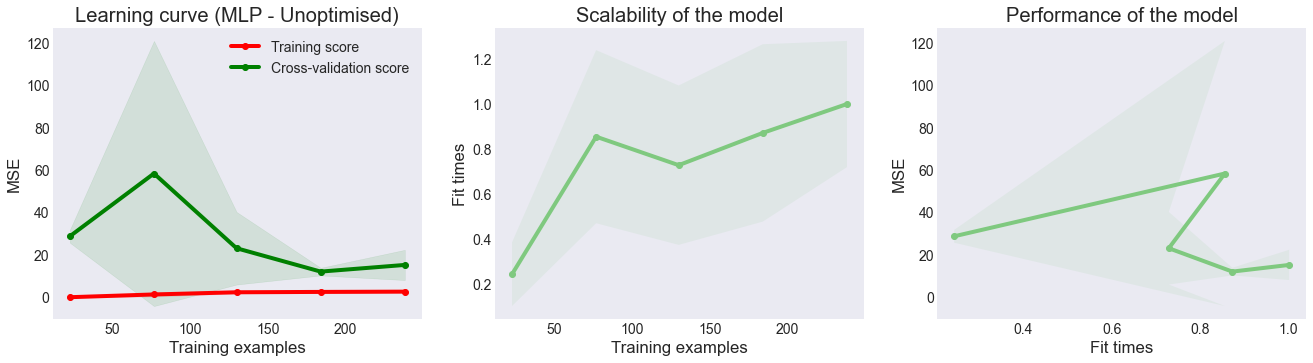

In [91]:
# Default value of 5 fold CV will be used.
title = r"Learning curve (MLP - Unoptimised)"
_ = plot_learning_curve(reg, title, X_train, y_train, cv=None, n_jobs=-1, learn_scoring="neg_mean_squared_error",
                        scoring_title="MSE")


The first obvious observation is how little variation there is in the accuracy of the training dataset. The plot is
however deceptive as the range of values for MPG is 0 to 50. Matplotlib increased the range of the y-axis scale in
order to display the full range of variation in the accuracy of the validation set (shaded green area).

The required level of granularity to understand the lower end of the MSE scale is therefore not available on this
plot. Nonetheless, relatively speaking the model bias is low. The variance for 1 sample is low, but increases
substantially when around 70 samples are used. For a completely unoptimised model this fluctuation in variance is
expected due to model overfitting.

The cross-validation accuracy decreases at around 180 samples and then plateaus.

Bearing in mind that this is an unoptimised model the overall variance reduction is encouraging. One would
however need to use a Validation Curve to better determine whether further optimisation can assist to further
decrease variance.

Based on the high variance (standard deviation) of the cross-validation score my guess would be that further
optimisation would provide a more stable variance result. Let's see if that is the case!

Now we optimise network architecture by manually investigating optimal No. of nodes.

We use the <i>relu</i> activation to ensure we converge on a solution, as our dataset is small (approximately 400
records) and hence more complex architectures can easily result in vanishing gradients. For the same reason we use
Cross-Validation with only 2 CV sets. We use MSE as an accuracy measure (scikit convention of using negative of the
MSE is inverted for our purposes).

In [92]:
validation_scores = {}
print("No. Nodes | MSE")

for hidden_layer_size in [(i,j) for i in range(2,8) for j in range(2,8)]:
    reg = MLPRegressor(max_iter = 10000000, solver = "lbfgs", activation = "relu", hidden_layer_sizes
    = hidden_layer_size, random_state = 1)
    score = cross_val_score(estimator = reg, X = X_train, y = y_train, cv = 2, scoring = "neg_mean_squared_error")
    validation_scores[hidden_layer_size] = -score.mean()
    print(hidden_layer_size, ": %0.5f" % validation_scores[hidden_layer_size])

No. Nodes | MSE
(2, 2) : 60.45355
(2, 3) : 33.52904
(2, 4) : 9.76136
(2, 5) : 8.78821
(2, 6) : 9.13712
(2, 7) : 8.87278
(3, 2) : 13.08227
(3, 3) : 12.51878
(3, 4) : 90.13538
(3, 5) : 10.70534
(3, 6) : 9.71167
(3, 7) : 10.54930
(4, 2) : 16.40770
(4, 3) : 12.27449
(4, 4) : 14.77715
(4, 5) : 11.13863
(4, 6) : 13.65372
(4, 7) : 13.62995
(5, 2) : 21.16919
(5, 3) : 10.55163
(5, 4) : 16.75536
(5, 5) : 36.23750
(5, 6) : 11.09529
(5, 7) : 22.57029
(6, 2) : 60.45355
(6, 3) : 17.51235
(6, 4) : 23.74991
(6, 5) : 26.65784
(6, 6) : 28.29946
(6, 7) : 20.62608
(7, 2) : 60.45355
(7, 3) : 15.59692
(7, 4) : 13.46804
(7, 5) : 19.68945
(7, 6) : 24.01455
(7, 7) : 48.77141


In [93]:
# Check scores
print("The highest validation score is: %0.4f" % min(validation_scores.values()))
optimal_hidden_layer_size = [name for name, score in validation_scores.items()
                              if score == min(validation_scores.values())][0]
print("This corresponds to nodes", optimal_hidden_layer_size )

The highest validation score is: 8.7882
This corresponds to nodes (2, 5)


A tiny improvement. We now have an MSE just under 9. Not really a true comparison as it was on the CV set, but good
enough for now. We can conclude that a simple model architecture suffices in this case.

We now perform regularisation to try and reduce overfitting more. We use an exponentially increasing series of numbers
around 0 as possible values for the regularisation parameter <i>alpha</i>.

In [94]:
reg_par = [np.e**n for n in np.arange(-3,6,1)]

validation_scores = {}
print(" alpha  |  MSE ")
for param in reg_par:
    reg = MLPRegressor(max_iter = 100000, solver = "lbfgs", activation = "relu", hidden_layer_sizes
    = optimal_hidden_layer_size, alpha = param, random_state = 1)
    score = cross_val_score(estimator = reg, X = X_train, y = y_train, cv = 2, scoring = "neg_mean_squared_error")
    validation_scores[param] = -score.mean()
    print("%0.5f |  %s" % (param, -score.mean()))

 alpha  |  MSE 
0.04979 |  8.75241839003218
0.13534 |  9.391364966685156
0.36788 |  9.53410504659648
1.00000 |  8.670066813564741
2.71828 |  9.159978307818427
7.38906 |  8.912088734060003
20.08554 |  8.337908977026725
54.59815 |  8.471529393089064
148.41316 |  11.278893212906699


Let us plot the values of the regularisation parameter against the accuracy measure i.e. MSE.

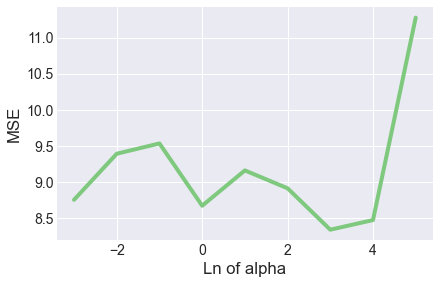

In [95]:
_ = plt.plot([np.log(i) for i in validation_scores.keys()], list(validation_scores.values()))
_ = plt.xlabel("Ln of alpha")
_ = plt.ylabel("MSE")

This plot clearly shows that regularisation has a marked effect on the accuracy of the validation set.

Let us look at a Validation Curve to better understand this effect.

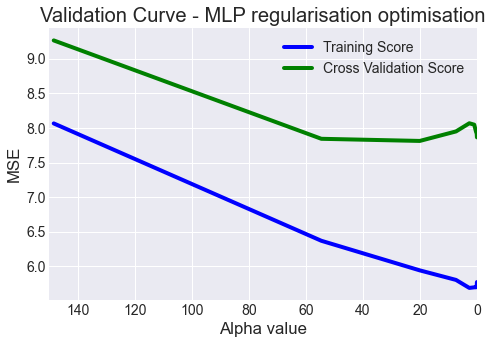

In [96]:
#reg_par_rev = reg_par.reverse()
#reg_par.reverse()
train_scores, test_scores = validation_curve(reg, X_train, y_train, "alpha", reg_par, cv=None,
                                              scoring="neg_mean_squared_error")

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Reverse scores to plot increasing complexity
train_scores_mean_rev = train_scores_mean[::-1]
train_scores_std = train_scores_std[::-1]
test_scores_mean_rev = test_scores_mean[::-1]
test_scores_std = test_scores_std[::-1]
reg_par_rev = reg_par[::-1]

fig, ax = plt.subplots(figsize=(7, 5))

# Plot mean accuracy scores for training and testing scores
ax.plot(reg_par_rev, train_scores_mean_rev, label = "Training Score", color = 'b')
ax.plot(reg_par_rev, test_scores_mean_rev, label = "Cross Validation Score", color = 'g')

# Creating the plot
ax.set_xlim(150,0)
ax.set_title("Validation Curve - MLP regularisation optimisation")
ax.set_xlabel("Alpha value")
ax.set_ylabel("MSE")

plt.tight_layout()
plt.legend(loc = 'best')
plt.show()


The validation curve shows that regularisation has a clear benefit to both the training and validation datasets. The
validation error plateaus at an alpha value of around 65, increases at around 20 and starts decreasing again at
values less than 1.

It is appears that a value of around 3 for the alpha parameter results in the lowest score.
We confirm this now by extracting the parameter from the list of parameters:

In [97]:
print("The lowest cross validation error is: %s" % (min(validation_scores.values())))
print("This corresponds to regularisation parameter e**%s" %
      ([np.log(name) for name, score in validation_scores.items()
                         if score==min(validation_scores.values())][0]))
optimal_alpha_param = [np.log(name) for name, score in validation_scores.items()
                         if score==min(validation_scores.values())][0]

The lowest cross validation error is: 8.337908977026725
This corresponds to regularisation parameter e**3.0


Yes, 3 is the optimal value for alpha.

We will use these hyperparameters on our test set as it is double the size of the CV set and measure the accuracy.

In [98]:
reg = MLPRegressor(max_iter=100000, solver="lbfgs", activation="relu", hidden_layer_sizes=optimal_hidden_layer_size,
                   alpha=np.e**(optimal_alpha_param), random_state=1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_pred,y_test)


6.160500749681907

The accuracy score on the optimised model reduced further to just over 6! Regularisation had a very positive effect on
model accuracy.
Let us look at the learning curve for the optimised model.

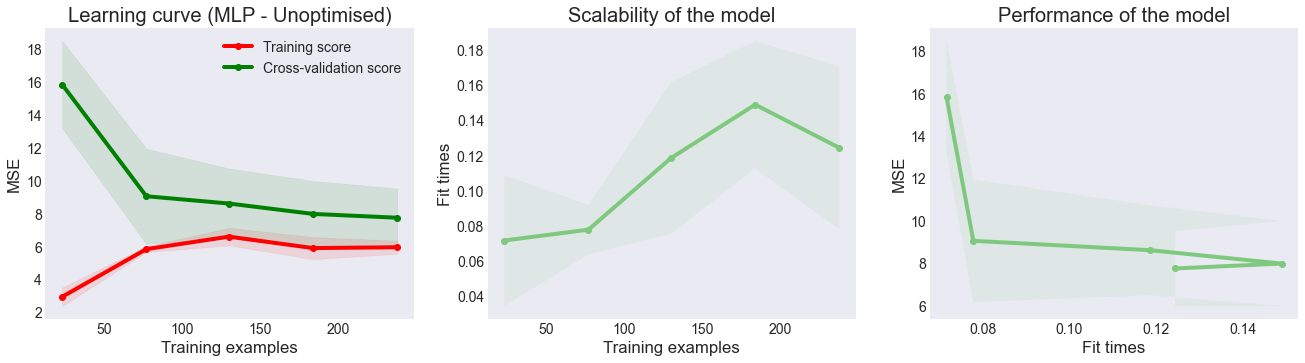

In [99]:
# Default value of 5 fold CV will be used.
title = r"Learning curve (MLP - Unoptimised)"
_ = plot_learning_curve(reg, title, X_train, y_train, cv=None, n_jobs=-1, learn_scoring="neg_mean_squared_error",
                        scoring_title="MSE")



The learning curve for the optimised MLP model looks pretty good. The variance is reduced to within a fraction of the
 value of the training set. The standard deviation of the cross-validation score is also substantially reduced.

Optimising alpha benefited the model considerably.

Now we will string everything together and build an automated model pipeline.


<h2 style = "font-family:verdana; background-color:#C5D6FA"><center>Build pipeline</center></h2>
<p><center style="color:#1F4BA7; font-family:cursive;">Using automatic hyperparameter tuning -
Pipeline & GridSearchCV</center></p>

We start by specifying some pipeline utility functions. Due to scikit-learn pipelines not supporting Dataframes we
have to write some functions to deal with conversion back to Dataframe. These ones are used to extract feature names
from pipeline mangled results :) Hopefully scikit-learn fixes this soon, then we can remove these functions.

In [100]:
# Obtaining dataframe columns from pipeline.
def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            return [f'vec_{f}' \
                for f in estimator.get_feature_names()]
        else:
            return estimator.get_feature_names(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in

def get_ct_feature_names(ct):
    output_features = []
    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])

    return output_features

These utility functions are used to build an ensemble pipeline which will be our final step in this pipeline adventure.

In [101]:
def get_models():
	models = list()
	models.append(LinearRegression())
	models.append(ElasticNet())
	models.append(SVR(gamma='scale'))
	models.append(DecisionTreeRegressor())
	models.append(KNeighborsRegressor())
	models.append(AdaBoostRegressor())
	models.append(BaggingRegressor(n_estimators=10))
	models.append(RandomForestRegressor(n_estimators=10))
	models.append(ExtraTreesRegressor(n_estimators=10))
	return models

def rmse(yreal, yhat):
	return sqrt(mean_squared_error(yreal, yhat))

def get_super_learner(X):
	ensemble = SuperLearner(scorer=rmse, folds=10, shuffle=True, sample_size=len(X))
	models = get_models()
	ensemble.add(models)
	ensemble.add_meta(LinearRegression())
	return ensemble



We start by getting a fresh dataset for the Pipeline.

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Then we build the pipeline. We start by doing Cross-Validation on our MLP model as before. We use our baseline model
and see if we can improve on it in the same way we did before, but now in an automated fashion.

In [103]:
reg = MLPRegressor(max_iter=100000, solver="lbfgs", activation="relu", hidden_layer_sizes=(5), random_state=1)

# Numeric transformations - for this dataset only missing values in numeric columns, so we don't have to impute the
# categorical variables. Need to change this if this is not the case.
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

# Final transformations, this includes OHE for categorical variables. Here we specify which columns to transform. Cool.
var_pipeline = ColumnTransformer(transformers = [
        ("num", num_pipeline, quantitative_cols_model),
        ("cat", OneHotEncoder(drop='first', handle_unknown='error'), categorical_cols),
        ])

# Pipeline including actual MLP model.
pipeline = Pipeline(steps =
                    [('var_prep', var_pipeline),
                     ('mlp_model', reg),
                     ])
# Set up cross validation object. Use three splits as this is a small dataset - cannot use less than 3, get an error.
cv = KFold(n_splits = 3, shuffle = True, random_state = 1)

# Run cross validation on pipeline.
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'neg_mean_squared_error', cv = cv, n_jobs = -1)
scores = absolute(scores)
print('MSE: %.3f (%.3f)' % (mean(scores), std(scores)))

MSE: 10.874 (0.789)


This is a good result! Ballpark same as our previous baseline result. We used CV of 3 here though. We can probably
come closer by tuning parameters but this is good enough for now.

To think all our transformations are magically correctly applied... Nice!

Now let us build our baseline model on the full training set i.e. not the CV set.

In [104]:
pipeline.fit(X_train, y_train)
#print(pipeline.data)
y_pred = pipeline.predict(X_test)
print('Baseline MLP model built with pipeline: MSE %.3f' % (mse(y_test, y_pred)))

Baseline MLP model built with pipeline: MSE 9.274


This is indeed very similar to our previous results. Some fluctuation is allowed for w.r.t. different number formats
used etc.

We now take a peak to see if our dataset built by the pipeline conforms to our previously built dataset. This is
where we use our utility functions.

In [105]:
X_train_simple = var_pipeline.fit_transform(X_train)
X_train_numpy = X_train_simple.toarray()
col_names_pipe = get_ct_feature_names(var_pipeline)
X_train_final = pd.DataFrame(X_train_numpy, columns = col_names_pipe)

In [106]:
X_train_final.head()

displacement  horsepower    weight  acceleration  cylinders_4  cylinders_5  \
0      0.071788   -0.516721 -0.008391      0.077693          0.0          0.0   
1     -1.122957   -1.417126 -1.170846      1.444064          1.0          0.0   
2     -0.515792   -0.434866 -0.097354      0.647014          1.0          0.0   
3     -0.936891   -0.325726 -0.811434      0.533150          1.0          0.0   
4     -1.054406   -1.062421 -1.182708      1.444064          1.0          0.0   

   cylinders_6  cylinders_8  model_year_71  model_year_72  ...  model_year_75  \
0          1.0          0.0            0.0            0.0  ...            0.0   
1          0.0          0.0            0.0            0.0  ...            0.0   
2          0.0          0.0            0.0            0.0  ...            0.0   
3          0.0          0.0            0.0            1.0  ...            0.0   
4          0.0          0.0            0.0            0.0  ...            0.0   

   model_year_76  model_year_77  model_year_78  model_year_79  model_year_80  \
0            0.0            0.0            1.0            0.0            0.0   
1            0.0            0.0            1.0            0.0            0.0   
2            0.0            0.0            0.0            1.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   model_year_81  model_year_82  origin_2  origin_3  
0            0.0            0.0       0.0       0.0  
1            0.0            0.0       0.0       1.0  
2            0.0            0.0       0.0       0.0  
3            0.0            0.0       0.0       1.0  
4            1.0            0.0       0.0       1.0  

[5 rows x 22 columns]

This looks perfect! Very happy indeed to have replicated transformation using a pipeline instead of manual
transformations.

Our final task is to use GridSearchCV to optimise our parameters from scratch i.e. not using previously found optimal
 parameters for the model. We do that next. This takes a while to run, so be patient!

We get our fresh datasets again.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [108]:
# We get our baseline MLP regressor again.
mlp_reg = MLPRegressor(max_iter=100000, solver="lbfgs", activation="relu", hidden_layer_sizes=(5), random_state=1)

# We build our pipeline - same as before.
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
    ])

# Note - scikit-learn gives an error if you don't specify handle_unknown = "error" here. Need to come back to this.
var_pipeline = ColumnTransformer(transformers = [
        ("num", num_pipeline, quantitative_cols_model),
        ("cat", OneHotEncoder(drop='first', handle_unknown='error'), categorical_cols),
        ])

pipeline = Pipeline(steps = [
        ('var_prep', var_pipeline),
        ('mlp', mlp_reg),
        ])

# Now we add the secret sauce! GridSearch
# We use the same parameters as before - for parity
layer_sizes = [(i,j) for i in range(2,8) for j in range(2,8)]

alphas = [np.e**n for n in np.arange(-3,6,1)]

# Define parameter grid - keep it at default for parity testing.
params = {
          #'mlp__activation': ['relu', 'tanh', 'logistic', 'identity'],
          #'mlp__activation': ['relu', 'tanh'],
          'mlp__activation': ['relu'],
          #'hidden_layer_sizes': list(itertools.permutations([50,100,150],2)) + list(itertools.permutations([50,100,
          # 150],3)) + [50,100,150],
          'mlp__alpha': alphas,
          'mlp__hidden_layer_sizes': layer_sizes,
          #'mlp__solver': ['adam', 'lbfgs'],
          'mlp__solver': ['lbfgs'],
          #'mlp__solver': ['adam'],
          #'mlp__learning_rate' : ['constant', 'adaptive', 'invscaling']
          'mlp__learning_rate' : ['constant']
         }

mlp_regressor_grid = GridSearchCV(pipeline, param_grid = params, n_jobs = -1, cv = 2, verbose = 5, scoring =
                    'neg_mean_squared_error')
                    #'neg_mean_squared_error', return_train_score=True)
mlp_regressor_grid = mlp_regressor_grid.fit(X_train, y_train)

Fitting 2 folds for each of 324 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   21.8s finished


In [109]:
res = pd.DataFrame(mlp_regressor_grid.cv_results_['params'])
res['score'] = mlp_regressor_grid.cv_results_['mean_test_score']
res.sort_values('score', ascending=False)

mlp__activation  mlp__alpha mlp__hidden_layer_sizes mlp__learning_rate  \
148            relu    2.718282                  (2, 6)           constant   
184            relu    7.389056                  (2, 6)           constant   
76             relu    0.367879                  (2, 6)           constant   
222            relu   20.085537                  (3, 2)           constant   
220            relu   20.085537                  (2, 6)           constant   
..              ...         ...                     ...                ...   
174            relu    2.718282                  (7, 2)           constant   
168            relu    2.718282                  (6, 2)           constant   
102            relu    0.367879                  (7, 2)           constant   
210            relu    7.389056                  (7, 2)           constant   
24             relu    0.049787                  (6, 2)           constant   

    mlp__solver      score  
148       lbfgs  -7.610133  
184       lbfgs  -7.622686  
76        lbfgs  -7.707352  
222       lbfgs  -7.755472  
220       lbfgs  -7.792659  
..          ...        ...  
174       lbfgs -60.453557  
168       lbfgs -60.453560  
102       lbfgs -60.453564  
210       lbfgs -60.453594  
24        lbfgs -60.459201  

[324 rows x 6 columns]

Wonderful. The baseline GridsearchCV seems to work. Modest increase in accuracy too. Happy days.

Now let us see if we can extract our best model and use it on the whole training set as before.

In [110]:
final_model = mlp_regressor_grid.best_estimator_

In [111]:
print (final_model)
print (final_model.get_params()['mlp__alpha'])
print (final_model.get_params()['mlp__hidden_layer_sizes'])

Pipeline(memory=None,
         steps=[('var_prep',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                 

Well this is encouraging. The results are very similar to the manual ones. This means we have a baseline and can
start optimising with a greater range of values.

Let us now build a model on the whole training set using these parameters and see what the results look like.

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [113]:
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print('Final model: MSE %.3f' % (mse(y_test, y_pred)))

Final model: MSE 6.210


Success! We obtain a similar result to the one we had when we built the model manually on the whole dataset! The
pipeline works.

Now our final step, we build an automated ensemble of models.

In [114]:
ensemble = get_super_learner(X_train)
pipeline = Pipeline(steps =
                    [('var_prep', var_pipeline),
                     ('ensemble', ensemble)
                     ])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Ensemble: MSE %.3f' % (mse(y_test, y_pred)))

Ensemble: MSE 8.422


Looks good. Again, ballpark the same as our manual method.

Another tool for our toolbox! Let us just double check our numbers by manually building datasets and running them
through the ensemble.

In [115]:
data_pipeline = Pipeline(steps =
                    [('var_prep', var_pipeline),
                     ])

X_train_pipe = data_pipeline.fit_transform(X_train)
X_test_pipe = data_pipeline.transform(X_test)

ensemble.fit(X_train_pipe, y_train)
print(ensemble.data)
y_pred = ensemble.predict(X_test_pipe)
print('Ensemble: MSE %.3f' % (mse(y_test, y_pred)))


                                  score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostregressor           3.80     0.62  0.84  0.12  0.08  0.02
layer-1  baggingregressor            3.60     1.01  0.28  0.02  0.02  0.01
layer-1  decisiontreeregressor       4.82     1.06  0.03  0.01  0.00  0.00
layer-1  elasticnet                  4.48     0.54  0.00  0.00  0.00  0.00
layer-1  extratreesregressor         3.42     0.88  0.23  0.02  0.01  0.01
layer-1  kneighborsregressor         3.31     0.84  0.00  0.00  0.01  0.01
layer-1  linearregression            3.06     0.61  0.04  0.01  0.00  0.00
layer-1  randomforestregressor       3.50     1.09  0.13  0.02  0.00  0.00
layer-1  svr                         3.64     1.03  0.01  0.00  0.00  0.00

Ensemble: MSE 7.633


Ballpark similar! Yay. Success!

That concludes this notebook for now. We succeeded in building a Pipeline for our simple MLP.

Our last step will be to do final model validation via plotting a response curve and performing some accuracy tests.

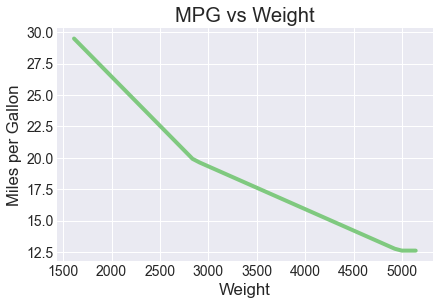

In [116]:
X_design = X.copy()
X_design_vec = pd.DataFrame(X_design.median()).transpose()
X_design_vec.head()

min_res = min(X.loc[:,"weight"])
max_res = max(X.loc[:,"weight"])
seq = np.linspace(start=min_res,stop=max_res,num=50)

to_predict = []
for result in seq:
    X_design_vec.loc[0,"weight"] = result
    to_predict.append(X_design_vec.copy())

to_predict = pd.concat(to_predict)
predictions = final_model.predict(to_predict)

plt.plot(seq,predictions)
plt.xlabel("Weight")
plt.ylabel("Miles per Gallon")
plt.title("MPG vs Weight")
plt.show()


It is clear that our model is accurate enough to capture the inversely proportionate relationship between MPG and
weight. This is a positive outcome, as it means the model as applied to the validation dataset managed to capture the
 underlying signals in the data. We can therefore conclude that the model generalises well and that its accuracy is
 sufficiently high for this model to be used based on the features captured.

Next we will do some actual over expected measurements to validate prediction accuracy for this regression model. We
will add this to the notebook during the next week!
